In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1500, 1000),
                               seed = 5678,
                               )

# skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
skin = tissue.Tissue(name='skin', c=1500, rho=1000, sigma=0, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=40, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
# tumor = tissue.Tissue(name='tumor', c=1550, rho=1050, sigma=0, scale=0.0001, label=5)
tumor = tissue.Tissue(name='tumor', c=1560, rho=1050, sigma=0, scale=0.001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [4]:
test = test_phantom.get_complete()

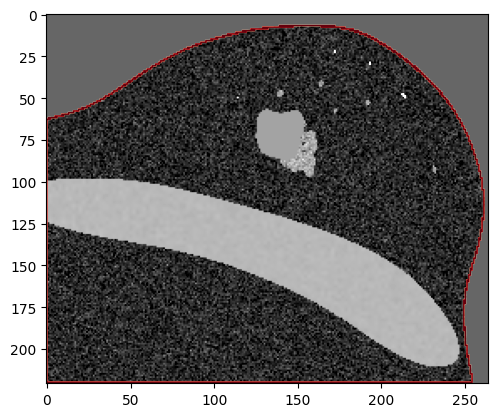

In [5]:
index = 140
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.5*(body_mask[:,:, index]>0)*2, cmap='Reds')

# Set up simulation

In [40]:
num_transducers = 400
# num_transducers = 1024
transducers = [transducer.Focused(max_frequency=1e6,
                                    elements = 1, 
                                    width = 1e-3,
                                    height =  1e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = (0,0),
                                    ray_num = (1,1),
                                    imaging_ndims = 3,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [41]:
import math

def fibonacci_sphere(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        x = 1 - (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        radius = math.sqrt(1 - x * x)
        theta = phi * i
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

In [42]:
global_transform = geometry.Transform([np.pi * 0.87,np.pi * -0.05,0],[-0.00,0.005,-0.01], intrinsic=False)
# coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi/2)
coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi/8)

for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, global_transform * geometry.Transform(angle, global_transform.apply_to_point(coord) * 0.06, intrinsic=False))

In [43]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

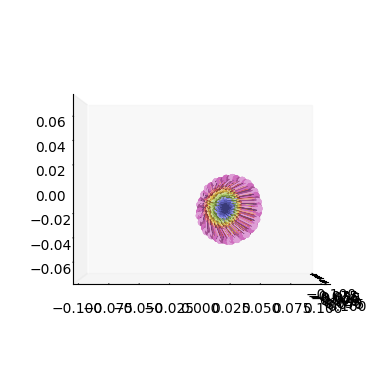

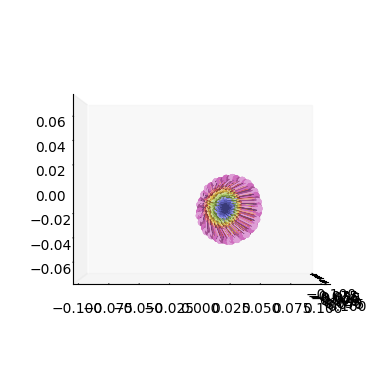

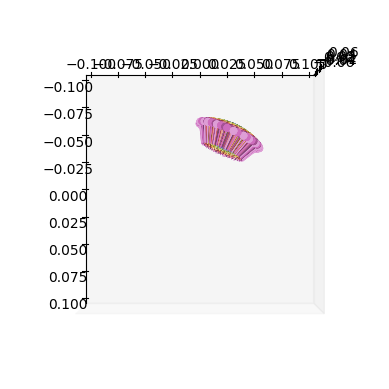

In [44]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/00_breast_single_VH_F_skin.obj")).sample_points_uniformly(2000).points)
points = points[:,[0,1,2]] - np.mean(points, axis=0) - np.array([0,0,np.min(points, axis=0)[2]])

test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0,0))
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0,0))
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(90,0))

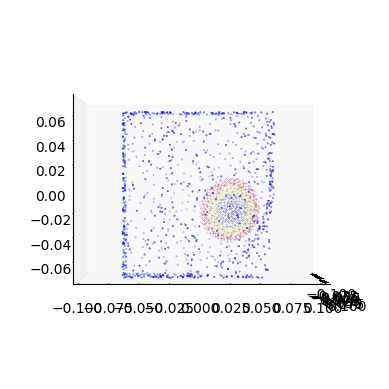

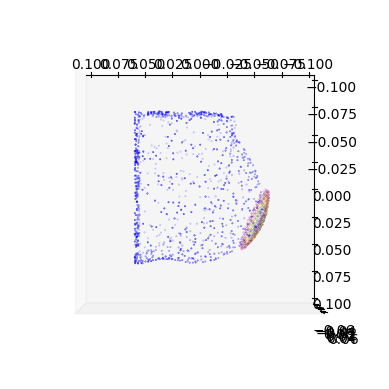

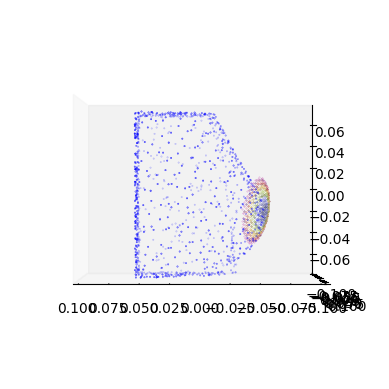

In [45]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/00_breast_single_VH_F_skin.obj")).sample_points_uniformly(1000).points)
points = points[:,[0,1,2]] - np.array(((np.amax(np.array(surface_mesh.vertices)[:,0]) + np.amin(np.array(surface_mesh.vertices)[:,0])) / 2,
                                       (np.amax(np.array(surface_mesh.vertices)[:,1]) + np.amin(np.array(surface_mesh.vertices)[:,1])) / 2,
                                       (np.amax(np.array(surface_mesh.vertices)[:,2]) + np.amin(np.array(surface_mesh.vertices)[:,2])) * -2))

test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(90,90))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,90))

In [46]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,100e-3,100e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [47]:
# test_experiment = experiment.Experiment(
#                  simulation_path = 'breast_tomography',
#                  sim_properties  = simprops,
#                  phantom         = test_phantom,
#                  transducer_set  = test_transducer_set,
#                  sensor          = test_sensor,
#                  nodes           = 1,
#                  results         = None,
#                  indices         = None,
#                  workers         = 3,
#                  additional_keys = []
#                  )

test_experiment = experiment.Experiment(
                 simulation_path = 'breast_3D_planewave_net',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [48]:
# utils.save_mrc(test_experiment.get_sensor_mask(pad=50), 'breast_tomography_sensor_mask.mrc')

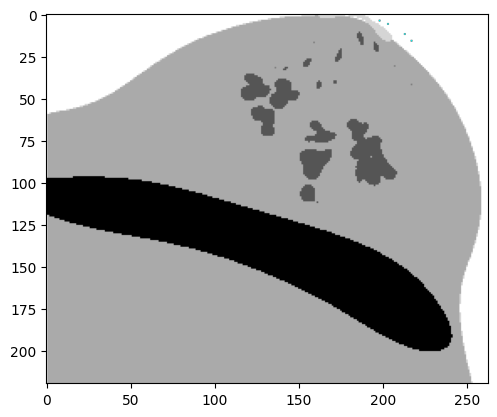

In [49]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

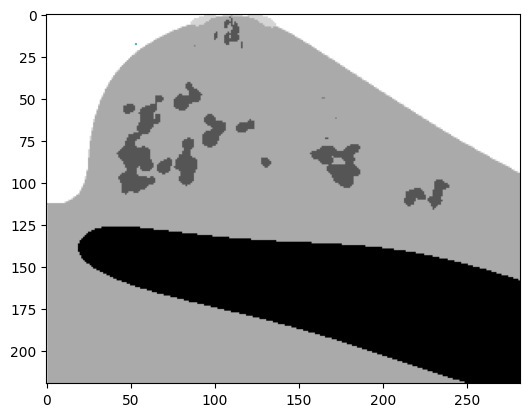

In [50]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 180, slice(0, -1, 1)])

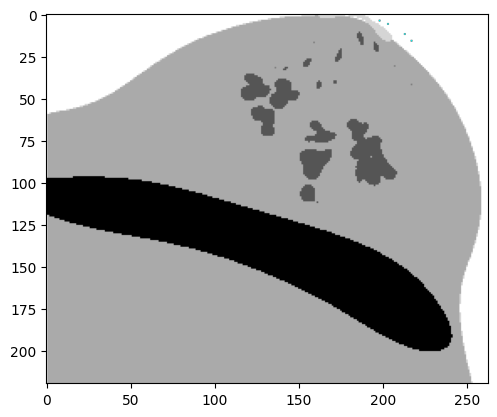

In [51]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

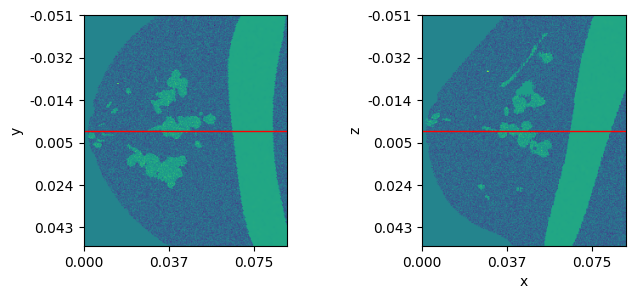

In [52]:
test_experiment.plot_ray_path(0)

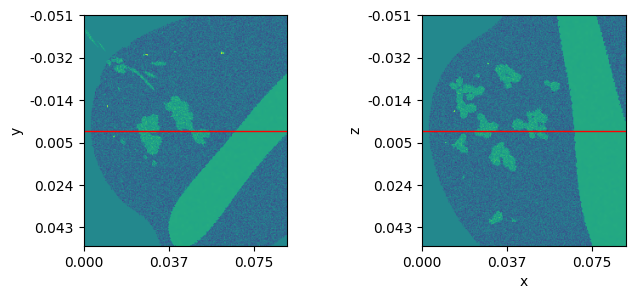

In [54]:
test_experiment.plot_ray_path(399)

# Run Simulation

In [2]:
test_experiment = experiment.Experiment.load('breast_3D_planewave_net')
test_experiment.run(dry=True)

dry run of simulation


  7%|▋         | 28/400 [00:10<02:19,  2.66it/s]


KeyboardInterrupt: 

In [ ]:
test_experiment.run(repeat=False)

running with 3 workers

preparation for sim    0 completed in 29.06 seconds
preparation for sim  200 completed in 29.09 seconds
preparation for sim    1 completed in 52.73 seconds
preparation for sim  201 completed in 34.85 seconds
simulation             0 completed in 38.57 seconds
simulation           200 completed in 41.30 seconds
preparation for sim    2 completed in 33.94 seconds
preparation for sim  202 completed in 35.38 seconds
simulation             1 completed in 46.08 seconds
simulation           201 completed in 38.48 seconds
preparation for sim    3 completed in 31.56 seconds
preparation for sim  203 completed in 31.06 seconds
simulation             2 completed in 42.55 seconds
simulation           202 completed in 38.16 seconds
preparation for sim  204 completed in 30.80 seconds
preparation for sim    4 completed in 31.42 seconds
simulation             3 completed in 40.94 seconds
simulation           203 completed in 38.11 seconds
preparation for sim  205 completed in 32

# Reconstruction

In [3]:
test_experiment = experiment.Experiment.load('breast_3D_planewave_net')
test_experiment.run(dry=True)
test_experiment.add_results()

dry run of simulation


100%|██████████| 400/400 [02:26<00:00,  2.73it/s]


In [4]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [5]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=1, combine=False, volumetric=True, attenuation_factor = 32, save_intermediates=True)

100%|██████████| 400/400 [00:00<00:00, 929485.65it/s]


running reconstruction on ray 0


In [ ]:
image2 = np.sum(images2, axis=0)/len(images2)


In [ ]:
print(image2.shape)

In [ ]:
plt.imshow(images2[0][:,:,7],)

In [ ]:
plt.imshow(image2[:,:,18])

In [ ]:
images3 = test_reconstruction.compound(workers=16, resolution_multiplier=0.5, local=True, combine=False, volumetric=False, attenuation_factor = 32)

In [ ]:
image3 = np.sum(images3, axis=0)/len(images3)

In [ ]:
plt.imshow(images3[23][:,:,0])

In [ ]:
plt.imshow(images3[15][:,:,0])

In [ ]:
plt.imshow(image3[:,:,0])

In [ ]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 140])

In [ ]:
plt.imshow(images2[5][:,:,90], vmin=0, vmax=4000)